In [1]:
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import control
# from ipywidgets import interact
tfin = 20
dt = 1/10
ts = np.linspace(0, tfin, round(tfin/dt))
s = sym.symbols('s', complex=True)


# Diseño de controladores mediante el Lugar Geométrico de las Raíces 

Juan Dvid Gallon Hernandez

Simon Uribe 

In [2]:
# Se define la función de transferencia del proceso
Gp = control.tf(0.27, [4.489, 1])
Gp

TransferFunction(array([0.27]), array([4.489, 1.   ]))

Si se realimenta el sistema con un compensador  𝐺𝑐(𝑠)=1

In [3]:
G_LC1 = control.feedback(Gp,1)
G_LC1

TransferFunction(array([0.27]), array([4.489, 1.27 ]))

Los polos y ceros del sistema en lazo cerrado serían:

In [4]:
# Polos de lazo con Gc(s) = 1
pLC1 = G_LC1.pole()
pLC1

array([-0.28291379])

In [5]:
# Ceros de lazo con Gc(s) = 1
cLC1 = G_LC1.zero()
cLC1

array([], dtype=float64)

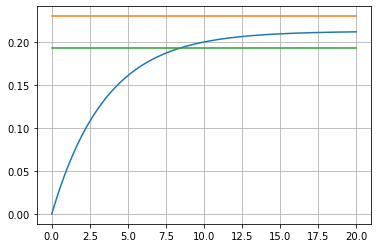

In [66]:
_, yLC1 = control.step_response(G_LC1,ts)
plt.plot(ts,yLC1,
         ts,0.23*np.ones(len(ts)),
         ts,0.193*np.ones(len(ts)))
plt.grid()

In [67]:
# Polos de lazo cerrado deseados
#pLC_deseado = 2*pLC1
#pLC_deseado
pLC_deseado = np.array([-8 + 8*1j,-8 + 8*1j])
pLC_deseado

array([-8.+8.j, -8.+8.j])

Se verifica si los polos deseados hacen parte del Lugar Geométrico de las Raíces.

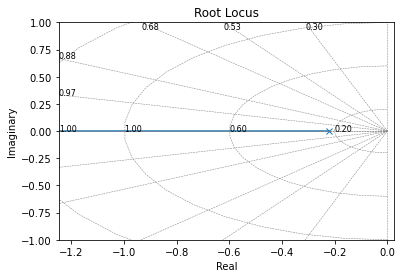

In [68]:
_,_ = control.root_locus(Gp,#FdT proceso
                         plot = True);
plt.plot(pLC_deseado.real, pLC_deseado.imag, 'r+')

In [69]:
G_p_sym = 0.27/(4.489*s+1)#FdT simbolica proceso
G_p_sym

0.27/(4.489*s + 1)

In [70]:
pLC_deseado

array([-8.+8.j, -8.+8.j])

In [71]:
#FdT proceso evaluada en un polo deseado
G_p_sym_des = G_p_sym.subs(s,pLC_deseado[0]).simplify()
G_p_sym_des 

-0.00375769056014605 - 0.00386532376821623*I

In [72]:
#norma de FdT proceso evaluada en un polo deseado

sym.Abs(G_p_sym_des) #SI LA MULTIPLICO POR EL INVERSO DA 1

0.00539082240283874

In [73]:
#fase de FdT proceso evaluada en un polo deseado

sym.arg(G_p_sym_des) #PA QUE SEA 1 LE FALTA PI/4

0.799516732730589 - pi

como la fase es 𝜋 
nos damos cuenta que el lugar geometrico de las raices pasa por el polo deseado 

In [74]:
#angulo que debe aportar el compensador para cumplir cond. de fase
ang_comp = -(sym.arg(G_p_sym_des) - sym.pi)
ang_comp

-0.799516732730589 + 2*pi

por lo que se requiere un compensador.  Se propone usar 

$$ G_c(s) = k_c\frac{s+\frac{1}{T}}{s+\frac{1}{\alpha T}}$$


In [75]:
#FdT simbolica del compensador 

kc,T,alpha,beta = sym.symbols('k_c,T,alpha,beta', real=True,positive = True)


G_c_sym = kc*(s+1/T)/(s+1/(alpha*T))
G_c_sym

k_c*(s + 1/T)/(s + 1/(T*alpha))

In [76]:
#El ángulo que aporta el compensador es:
sym.arg(G_c_sym.subs(s,pLC_deseado[0]).simplify())

arg((8.0*T*(-1 + I) + 1)/(8.0*T*alpha*(-1 + I) + 1))

Observe que tiene dos parámetros y una sola condición. En este caso se selecciona un parámetro de forma arbitraria para determinar el otro.

Una posible solución es ubicar el cero del compensador bajo el polo deseado.

El cero del compensador cumple:
$$s+\frac{1}{T} = 0$$
Como se desea en $s=-7$
$$-7+\frac{1}{T} = 0$$
$$T = \frac{1}{7}$$

y se soluciona la condición de fase

In [77]:
parametros = {T:1/8} #NOS FALTA UNA ECUACION ASI QUE NOS TOCA DARLE ALGUN VALOR A ALGUNA VARIABLE

In [78]:
CondFase = sym.arg(G_c_sym.subs(s,pLC_deseado[0]).
                   subs(parametros))-ang_comp
CondFase

arg(I/(-1 + I + 1/alpha)) - 2*pi + 0.799516732730589

In [79]:
CondFase = sym.arg(G_c_sym.subs(s,pLC_deseado[0]).
                   subs(parametros))-ang_comp
sym.solve(CondFase,alpha)
#alpha

[]

In [80]:
parametros = {T:1/8, alpha:0.10}

In [81]:
#FdT simbolica del compensador con los parametros hasta el momento

G_c_sym.subs(parametros)

k_c*(s + 8.0)/(s + 80.0)

Así, el compensador es:

$$G_c(s) = k_c \frac{s+2}{s+4}$$

Y falta encontrar $k_c$

In [82]:
#FdT  del compensador para simular

Gc = control.tf([1,2],[1,4])
Gc

TransferFunction(array([1, 2]), array([1, 4]))

In [83]:
G = Gc*Gp
G

TransferFunction(array([0.27, 0.54]), array([ 4.489, 18.956,  4.   ]))

El Lugar Geométrico de las Raíces del proceso y el compensador es:

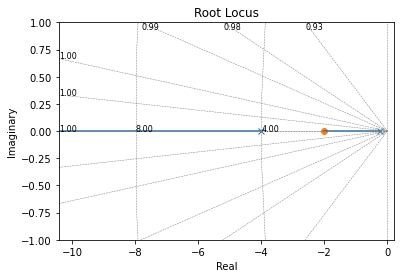

In [84]:
_,_ = control.root_locus(Gc*Gp,
                         plot = True);
plt.plot(pLC_deseado.real, pLC_deseado.imag, 'r+')

Ahora debe hallarse $k_c$ con la condición de magnitud.

Ya se ha calculado que la magnitud del proceso evaluado en el polo deseado es:

In [85]:
sym.Abs(G_p_sym_des)

0.00539082240283874

In [86]:
mag_comp = 1/sym.Abs(G_p_sym_des)
#magnitud que debe tener el compensador para cumplir cond.

In [87]:
CondMag = sym.Abs(G_c_sym.subs(s,pLC_deseado[0]).
                   subs(parametros))/mag_comp - 1
sym.solve(CondMag,kc)
#valorKc

[1679.77804896132]

In [88]:
parametros = {T:1/8, alpha:0.10, kc:1679.7}

Y  el compensador es:

In [89]:
G_c_sym.subs(parametros)

1679.7*(s + 8.0)/(s + 80.0)

In [90]:
Gc = 2*control.tf([1,2],[1,4])
Gc

TransferFunction(array([2, 4]), array([1, 4]))

**Respuesta al escalón del proceso sin compensador**

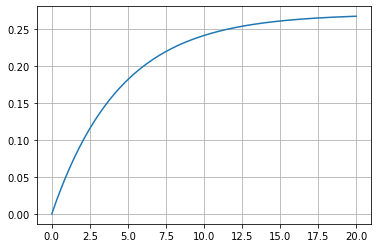

In [91]:

_, yLA = control.step_response(Gp, ts)
plt.plot(ts,yLA)
plt.grid()

**Respuesta al escalón del proceso realimentado**

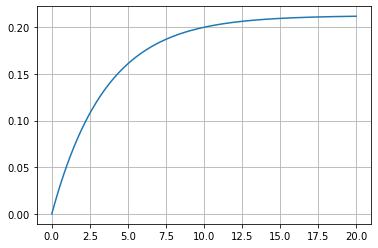

In [92]:
_, yLC1 = control.step_response(control.feedback(Gp,1),ts)
plt.plot(ts,yLC1)
plt.grid()


**Respuesta al escalón del proceso con compensador**


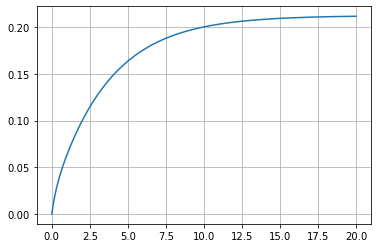

In [93]:
_, yLC = control.step_response(control.feedback(Gc*Gp,1),ts)
plt.plot(ts,yLC)
plt.grid()


Puede compararse la respuesta del sistema solo realimentado con la respuesta del sistema compensado

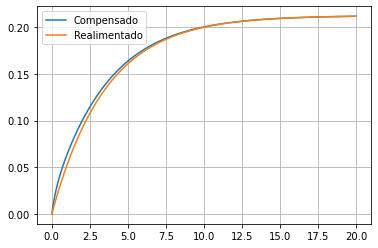

In [94]:
plt.plot(ts,yLC,ts,yLC1)
plt.legend(('Compensado','Realimentado'))
plt.grid()

# Compensador en retardo

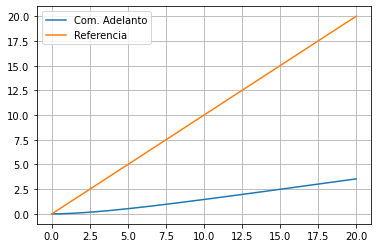

In [95]:

_, yLCr = control.step_response(control.feedback(Gc*Gp,1)*
                                control.tf(1,[1,0]),ts)
plt.plot(ts,yLCr)
plt.plot([ts[0],ts[-1]], [0,ts[-1]])
plt.legend(('Com. Adelanto','Referencia'))
plt.grid()

TransferFunction(array([0.54, 1.08]), array([ 4.489, 18.956,  4.   ]))

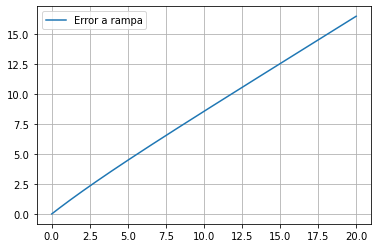

In [96]:
plt.plot(ts,ts-yLCr,
         label = 'Error a rampa')
plt.legend()
plt.grid()
Gc*Gp

In [97]:
Gc*Gp

TransferFunction(array([0.54, 1.08]), array([ 4.489, 18.956,  4.   ]))

In [98]:
1.08/4.489

0.2405881042548452

El error de estado estable ante la rampa puede disminuirse a $0.025$, por ejemplo. Para lograr esto, se selecciona $\beta = 10$, entonces el compensador en retardo es:


$$ k_c\frac{s+\frac{1}{T}}{s+\frac{1}{10 T}}$$

Como se requiere que el compensador no altere de manera significativa el **LGDR**, se toma $T$ de manera que su polo y cero estén "cercanos", por ejemplo $40$, por lo que el controlador es:

$$ k_c\frac{s+\frac{1}{40}}{s+\frac{1}{400}} = k_c\frac{s+0.025}{s+0.0025}$$


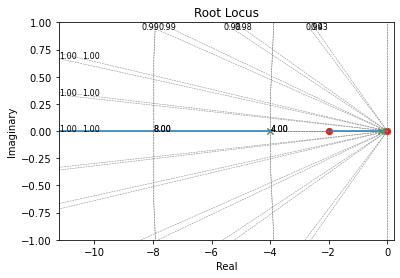

In [99]:
G_at = control.tf([1,0.025],[1,0.0025])

_,_ = control.root_locus(Gc*Gp,plot = True);
_,_ = control.root_locus(G_at*Gc*Gp,plot = True);
plt.plot(pLC_deseado.real, pLC_deseado.imag, 'r+')

In [100]:
G_at_sym = kc*(s+1/T)/(s+1/(beta*T))
G_at_sym

k_c*(s + 1/T)/(s + 1/(T*beta))

In [101]:
GLA_sym = (G_at_sym.subs({T:40,
                          beta:10})*
           G_c_sym.subs(parametros)*
           G_p_sym)
GLA_sym

453.519*k_c*(s + 1/40)*(s + 8.0)/((s + 1/400)*(s + 80.0)*(4.489*s + 1))

In [102]:
sym.Abs(GLA_sym.subs(s,pLC_deseado[0])).simplify()

0.998548342289359*k_c

In [103]:
kc/sym.Abs(GLA_sym.subs(s,pLC_deseado[0])).simplify()

1.00145376808429

El compensador en atraso será entonces:

$$  1.001407\frac{s+0.025}{s+0.0025}$$


El sistema compensado completo es:

In [104]:
G_at = 1.0056*control.tf([1,0.025],[1,0.0025])
G = G_at*Gc*Gp
G

TransferFunction(array([0.543024 , 1.0996236, 0.0271512]), array([4.48900000e+00, 1.89672225e+01, 4.04739000e+00, 1.00000000e-02]))

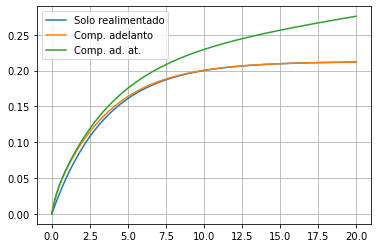

In [105]:

_, yLC_aa = control.step_response(control.feedback(G_at*Gc*Gp,1),ts)
plt.plot(ts,yLC1,
         ts,yLC,
         ts,yLC_aa)
plt.legend(('Solo realimentado','Comp. adelanto','Comp. ad. at.'))
plt.grid()

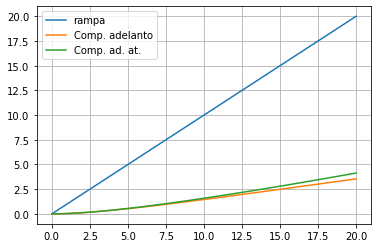

In [106]:
## Respuestas ante la rampa 
_, yLC_aar = control.step_response(control.feedback(G_at*Gc*Gp,1)*
                                  control.tf(1,[1,0]),ts)
plt.plot(ts,ts,
         ts,yLCr,
         ts,yLC_aar)
plt.legend(('rampa','Comp. adelanto','Comp. ad. at.'))
plt.grid()

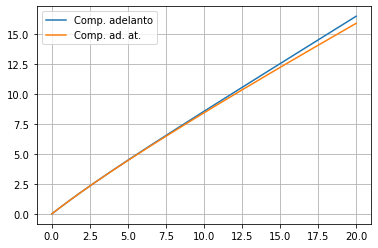

In [107]:
## error ante la rampa

plt.plot(ts,ts-yLCr,
         ts,ts-yLC_aar)
plt.legend(('Comp. adelanto','Comp. ad. at.'))
plt.grid()